## Pretty bad

In [20]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch_geometric.data import Data
from rdkit import Chem
from rdkit.Chem import AllChem
from torch_geometric.loader import DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [5]:
df = pd.read_csv("/Users/williamsilver/Ai in materials workshop/AI-in-materials-workshop/AI-in-materials-workshop/mmc2_cleaned_2_no_zero_pce.csv")

In [39]:
def get_atom_features(atom):
    # Standard categorical features for nodes
    features = [
        atom.GetAtomicNum(),
        atom.GetDegree(),
        atom.GetFormalCharge(),
        atom.GetHybridization().real,
        atom.GetIsAromatic() * 1.0,
        atom.GetTotalNumHs(),
    ]
    return features

def get_bond_features(bond):
    # Standard categorical features for edges
    bt = bond.GetBondType()
    bond_feats = [
        bt == Chem.rdchem.BondType.SINGLE,
        bt == Chem.rdchem.BondType.DOUBLE,
        bt == Chem.rdchem.BondType.TRIPLE,
        bt == Chem.rdchem.BondType.AROMATIC,
        bond.GetIsConjugated() * 1.0,
        bond.IsInRing() * 1.0,
    ]
    return bond_feats

def smiles_to_graph(smiles, targets):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None

    # Node features
    node_feats = [get_atom_features(atom) for atom in mol.GetAtoms()]
    x = torch.tensor(node_feats, dtype=torch.float)

    # Edge index / edge attr
    edge_indices = []
    edge_feats = []
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        edge_indices += [[i, j], [j, i]]
        feat = get_bond_features(bond)
        edge_feats += [feat, feat]

    if len(edge_indices) == 0:
        edge_index = torch.empty((2, 0), dtype=torch.long)
        edge_attr  = torch.empty((0, 6), dtype=torch.float)
    else:
        edge_index = torch.tensor(edge_indices, dtype=torch.long).t().contiguous()
        edge_attr  = torch.tensor(edge_feats, dtype=torch.float)

    # Targets (4 values)
    y = torch.tensor([targets], dtype=torch.float)  # shape (1, 4)

    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)

In [40]:
final_graphs = []
for _, row in tqdm(df.iterrows(), total=len(df)):
    targets = [row['homo'], row['lumo'], row['gap'], row['pce']]
    g = smiles_to_graph(row['smiles'], targets)
    if g is not None:
        final_graphs.append(g)

print(f"Created {len(final_graphs)} graph objects.")

graph_list = final_graphs  # <-- keep as list

100%|██████████| 48357/48357 [00:25<00:00, 1924.80it/s]


Created 48357 graph objects.


In [41]:
bad = [type(g) for g in graph_list if not isinstance(g, Data)]
print("Non-Data types found:", set(bad))

# Hard fail if anything isn't Data
assert all(isinstance(g, Data) for g in graph_list), "graph_list contains non-Data objects (e.g., strings)."

Non-Data types found: set()


In [42]:
from torch_geometric.nn import GINEConv, global_mean_pool, BatchNorm

class MoleculeGNN(nn.Module):
    def __init__(self, node_in_dim, edge_in_dim, hidden_dim=128):
        super(MoleculeGNN, self).__init__()
        
        # 1. Initial Encoders: Map raw features to hidden space
        self.node_encoder = nn.Linear(node_in_dim, hidden_dim)
        self.edge_encoder = nn.Linear(edge_in_dim, hidden_dim)
        
        # 2. GNN Layers: Using GINEConv to incorporate bond features
        # We stack 4 layers for "4-hop" chemical reasoning
        self.conv1 = GINEConv(nn.Sequential(nn.Linear(hidden_dim, hidden_dim), nn.ReLU(), nn.Linear(hidden_dim, hidden_dim)))
        self.bn1 = BatchNorm(hidden_dim)
        
        self.conv2 = GINEConv(nn.Sequential(nn.Linear(hidden_dim, hidden_dim), nn.ReLU(), nn.Linear(hidden_dim, hidden_dim)))
        self.bn2 = BatchNorm(hidden_dim)
        
        self.conv3 = GINEConv(nn.Sequential(nn.Linear(hidden_dim, hidden_dim), nn.ReLU(), nn.Linear(hidden_dim, hidden_dim)))
        self.bn3 = BatchNorm(hidden_dim)

        # 3. Prediction Head: Multi-task output (3 targets)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, 4)  # homo, lumo, gap, pce
        )

    def forward(self, x, edge_index, edge_attr, batch):
        # Initial embedding
        x = self.node_encoder(x)
        edge_attr = self.edge_encoder(edge_attr)
        
        # Message passing layers
        x = self.bn1(torch.relu(self.conv1(x, edge_index, edge_attr)))
        x = self.bn2(torch.relu(self.conv2(x, edge_index, edge_attr)))
        x = self.bn3(torch.relu(self.conv3(x, edge_index, edge_attr)))
        
        # 4. Global Pooling: Reduce atom-level features to a single molecule-level vector
        x = global_mean_pool(x, batch)
        
        # 5. Regression
        return self.fc(x)

# Example Initialization
# node_in_dim = 6 (from previous script), edge_in_dim = 6 (from previous script)
model = MoleculeGNN(node_in_dim=6, edge_in_dim=6, hidden_dim=128)

In [43]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0
    n = 0

    for batch in loader:
        batch = batch.to(device)
        optimizer.zero_grad()

        pred = model(batch.x, batch.edge_index, batch.edge_attr, batch.batch)
        y = batch.y.view(pred.shape).to(device)  # align shapes

        loss = criterion(pred, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * batch.num_graphs
        n += batch.num_graphs

    return total_loss / max(n, 1)

@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0.0
    n = 0

    for batch in loader:
        batch = batch.to(device)
        pred = model(batch.x, batch.edge_index, batch.edge_attr, batch.batch)
        y = batch.y.view(pred.shape).to(device)

        loss = criterion(pred, y)
        total_loss += loss.item() * batch.num_graphs
        n += batch.num_graphs

    return total_loss / max(n, 1)

In [47]:
import copy
import numpy as np
import torch
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data

# --- storage for out-of-fold preds ---
oof_true = []
oof_pred = []

# Safety: filter only Data objects
graph_list = [g for g in graph_list if isinstance(g, Data)]
assert len(graph_list) > 0, "No valid graphs found."

kf = KFold(n_splits=5, shuffle=True, random_state=42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
fold_results = []

target_names = ["HOMO", "LUMO", "Gap", "PCE"]

for fold, (train_idx, val_idx) in enumerate(kf.split(graph_list)):
    print(f"\n--- Starting Fold {fold+1}/5 ---")

    train_set = [copy.deepcopy(graph_list[i]) for i in train_idx]
    val_set   = [copy.deepcopy(graph_list[i]) for i in val_idx]

    # Fit scaler on TRAIN targets only
    train_y_raw = np.vstack([g.y.detach().cpu().numpy() for g in train_set])  # (N,4)
    scaler = StandardScaler().fit(train_y_raw)

    # Apply scaling to train/val targets
    for g in train_set:
        y_np = g.y.detach().cpu().numpy()
        g.y = torch.tensor(scaler.transform(y_np), dtype=torch.float)

    for g in val_set:
        y_np = g.y.detach().cpu().numpy()
        g.y = torch.tensor(scaler.transform(y_np), dtype=torch.float)

    train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
    val_loader   = DataLoader(val_set, batch_size=64, shuffle=False)

    model = MoleculeGNN(node_in_dim=6, edge_in_dim=6, hidden_dim=128).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = torch.nn.MSELoss()

    best_val_loss = float("inf")

    # ---- train ----
    for epoch in range(10):
        train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
        val_loss   = evaluate(model, val_loader, criterion, device)
        best_val_loss = min(best_val_loss, val_loss)

        print(f"Fold {fold+1} | Epoch {epoch:02d} | Train MSE: {train_loss:.4f} | Val MSE: {val_loss:.4f}")

    fold_results.append(best_val_loss)

    # ---- collect OUT-OF-FOLD predictions ONCE (after training) ----
    model.eval()
    fold_true_batches = []
    fold_pred_batches = []

    with torch.no_grad():
        for batch in val_loader:
            batch = batch.to(device)

            preds = model(batch.x, batch.edge_index, batch.edge_attr, batch.batch)

            preds = preds.detach().cpu().numpy()
            y_true = batch.y.detach().cpu().numpy()

            # inverse transform back to original units
            preds = scaler.inverse_transform(preds)
            y_true = scaler.inverse_transform(y_true)

            fold_pred_batches.append(preds)
            fold_true_batches.append(y_true)

    fold_pred = np.vstack(fold_pred_batches)
    fold_true = np.vstack(fold_true_batches)

    oof_pred.append(fold_pred)
    oof_true.append(fold_true)

# ---- final out-of-fold arrays ----
y_pred = np.vstack(oof_pred)
y_true = np.vstack(oof_true)

print(f"\nAverage 5-Fold best Val MSE: {np.mean(fold_results):.4f}")

# ---- R2 per target ----
print("\nOut-of-fold R² by target:")
for i, name in enumerate(target_names):
    r2 = r2_score(y_true[:, i], y_pred[:, i])
    print(f"{name}: R² = {r2:.3f}")



--- Starting Fold 1/5 ---
Fold 1 | Epoch 00 | Train MSE: 0.2923 | Val MSE: 0.9970
Fold 1 | Epoch 01 | Train MSE: 0.1989 | Val MSE: 0.4984
Fold 1 | Epoch 02 | Train MSE: 0.1715 | Val MSE: 0.2774
Fold 1 | Epoch 03 | Train MSE: 0.1546 | Val MSE: 0.3936
Fold 1 | Epoch 04 | Train MSE: 0.1459 | Val MSE: 1.1746
Fold 1 | Epoch 05 | Train MSE: 0.1367 | Val MSE: 0.9290
Fold 1 | Epoch 06 | Train MSE: 0.1283 | Val MSE: 0.7607
Fold 1 | Epoch 07 | Train MSE: 0.1224 | Val MSE: 0.1963
Fold 1 | Epoch 08 | Train MSE: 0.1190 | Val MSE: 0.3429
Fold 1 | Epoch 09 | Train MSE: 0.1128 | Val MSE: 0.2183

--- Starting Fold 2/5 ---
Fold 2 | Epoch 00 | Train MSE: 0.2764 | Val MSE: 0.6522
Fold 2 | Epoch 01 | Train MSE: 0.1918 | Val MSE: 0.8008
Fold 2 | Epoch 02 | Train MSE: 0.1748 | Val MSE: 0.4963
Fold 2 | Epoch 03 | Train MSE: 0.1546 | Val MSE: 1.5489
Fold 2 | Epoch 04 | Train MSE: 0.1435 | Val MSE: 0.3999
Fold 2 | Epoch 05 | Train MSE: 0.1350 | Val MSE: 0.5784
Fold 2 | Epoch 06 | Train MSE: 0.1305 | Val MSE: 0

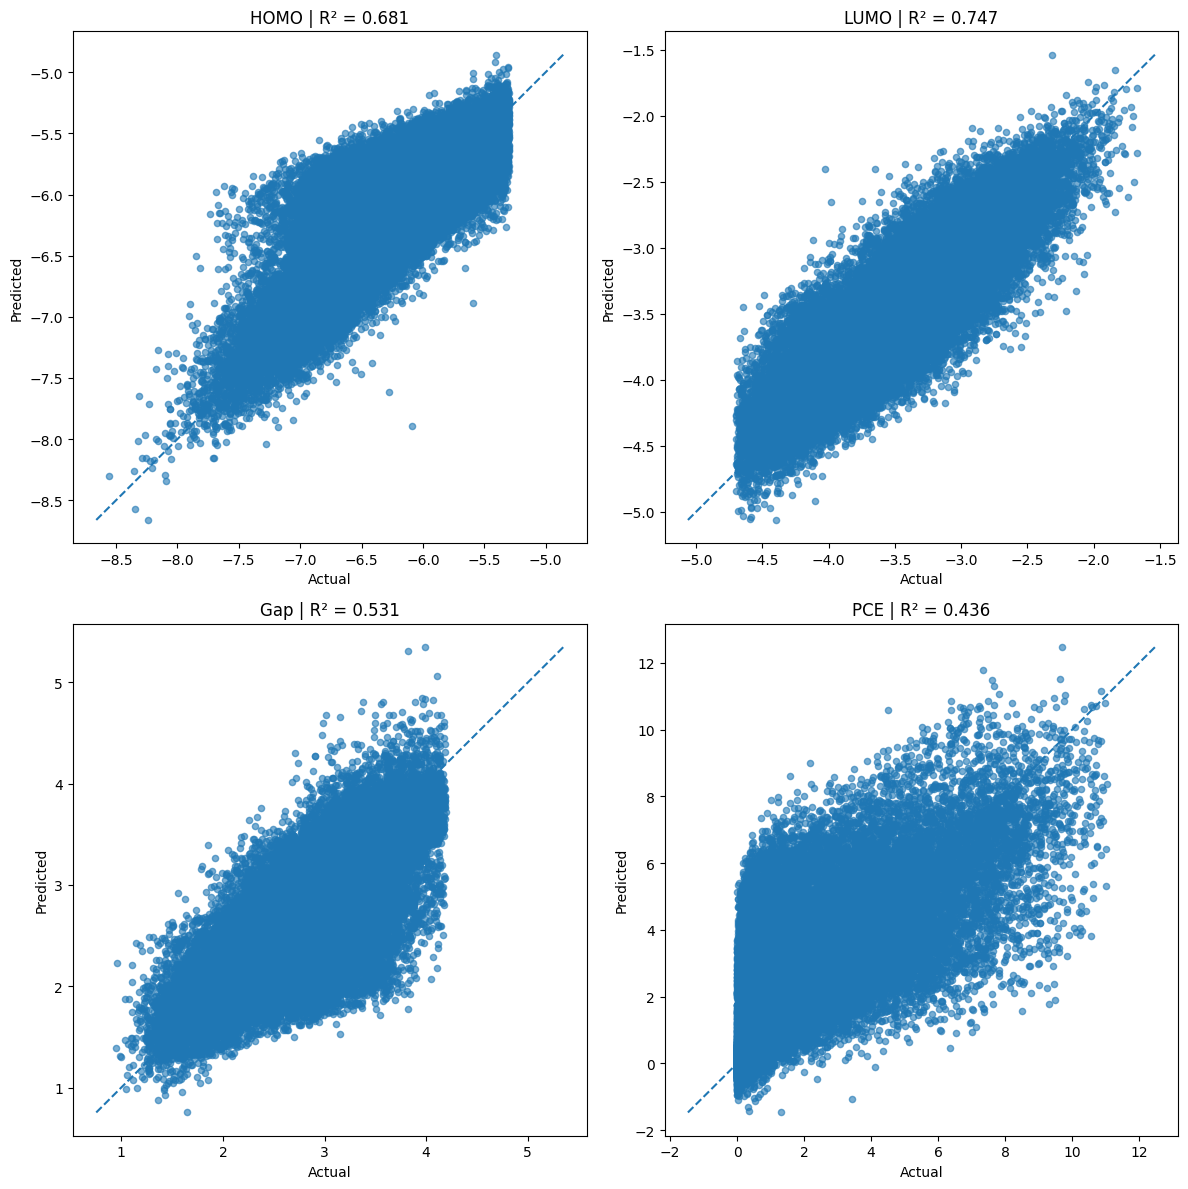

In [48]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.flatten()

for i, name in enumerate(target_names):
    ax = axes[i]
    ax.scatter(y_true[:, i], y_pred[:, i], alpha=0.6, s=20)

    lo = min(y_true[:, i].min(), y_pred[:, i].min())
    hi = max(y_true[:, i].max(), y_pred[:, i].max())
    ax.plot([lo, hi], [lo, hi], linestyle="--")

    r2 = r2_score(y_true[:, i], y_pred[:, i])
    ax.set_title(f"{name} | R² = {r2:.3f}")
    ax.set_xlabel("Actual")
    ax.set_ylabel("Predicted")

plt.tight_layout()
plt.show()